<a href="https://colab.research.google.com/github/gauravgupt8/Data-Science-Dissertation/blob/main/Kidney_Early_Detection_Dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone


In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
# ============================================
#  Toggle which models to run (speed control)
# ============================================
RUN_CNN = True
RUN_LENET = True   # set True if you want to include LeNet
RUN_MOBILENET = True

# ============================================
# 1. Import and Setup Required modules
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    AveragePooling2D, GlobalAveragePooling2D
)
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

warnings.filterwarnings("ignore")

# Load Image Paths and Labels into a DataFrame

In [ ]:
# ===================================
# 2. Load Image Paths and Labels
# ===================================

data_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

filepaths = []
labels = []

for folder in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, folder)
    for filename in os.listdir(class_folder):
        filepaths.append(os.path.join(class_folder, filename))
        labels.append(folder)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print("Dataset loaded with shape:", df.shape)


Dataset loaded with shape: (12446, 2)


# Basic Exploratory Data Analysis (EDA)

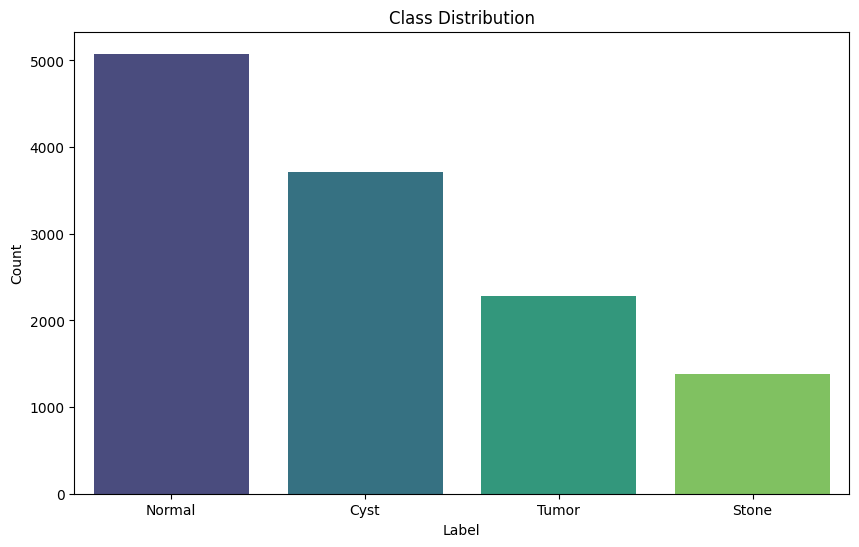

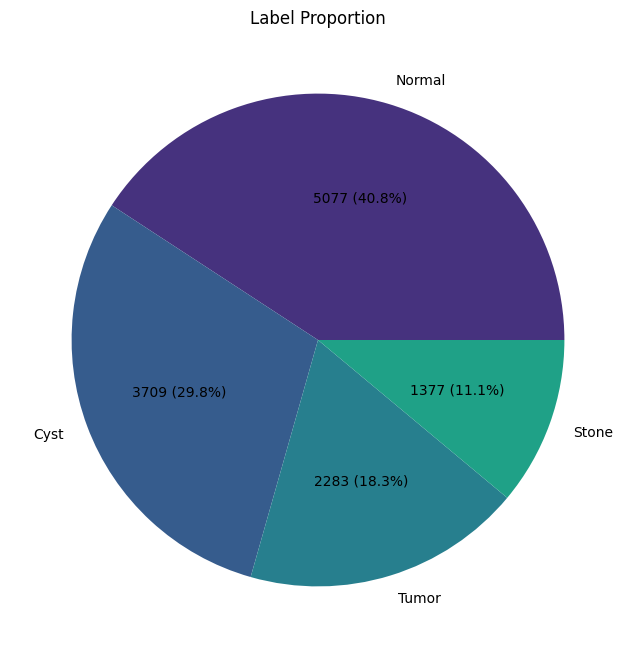

Duplicate filepaths: 0


In [ ]:
# ========================
# 3. Basic EDA
# ========================

# Plot class distribution bar chart
label_counts = df['label'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Plot class distribution pie chart
plt.figure(figsize=(8, 8))
# plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.pie(label_counts.values, labels=label_counts.index,
        autopct=lambda pct: f'{int(round(pct * sum(label_counts.values) / 100))} ({pct:.1f}%)',
        colors=sns.color_palette('viridis'))
plt.title('Label Proportion')
plt.show()

# Check for duplicate filepaths
print("Duplicate filepaths:", df['filepath'].duplicated().sum())


# Image Shape Consistency Check

---



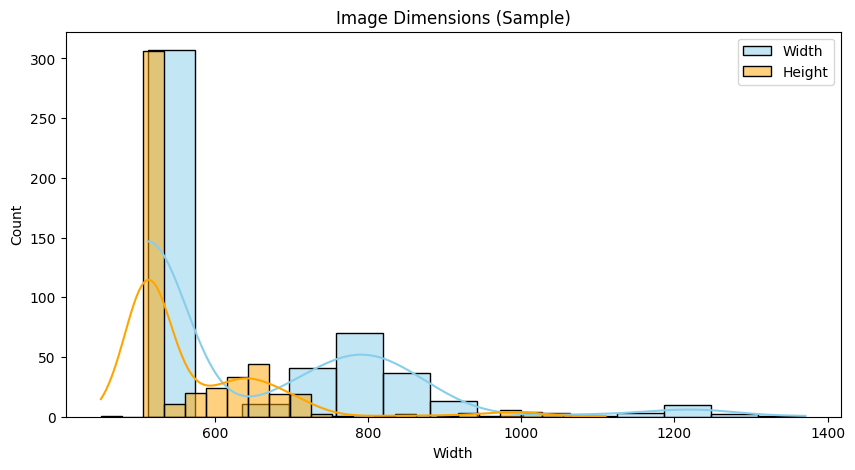

Corrupt images found: 0


In [ ]:
# ===============================
# 4. Image Shape Consistency
# ===============================

shapes = []
corrupt = 0

# Sample 500 images to check sizes
for path in df['filepath'].sample(500):
    try:
        with Image.open(path) as img:
            shapes.append(img.size)
    except:
        corrupt += 1

shape_df = pd.DataFrame(shapes, columns=['Width', 'Height'])

# Plot histograms for width and height
plt.figure(figsize=(10, 5))
sns.histplot(shape_df['Width'], color='skyblue', label='Width', kde=True)
sns.histplot(shape_df['Height'], color='orange', label='Height', kde=True)
plt.legend()
plt.title("Image Dimensions (Sample)")
plt.show()

print("Corrupt images found:", corrupt)


# Train-Validation-Test Split

In [ ]:
# ====================================
# 5. Split the Data in Train(70%), Validation(15%) and Test(15%)
# ====================================

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=19)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=19)

print("Train size:", train_df.shape)
print("Validation size:", valid_df.shape)
print("Test size:", test_df.shape)

# Confirm label balance across splits
for split_name, split_df in zip(["Train", "Validation", "Test"], [train_df, valid_df, test_df]):
    print(f"\n{split_name} split distribution:\n", split_df['label'].value_counts(normalize=True))


Train size: (8712, 2)
Validation size: (1867, 2)
Test size: (1867, 2)

Train split distribution:
 label
Normal    0.407943
Cyst      0.297980
Tumor     0.183425
Stone     0.110652
Name: proportion, dtype: float64

Validation split distribution:
 label
Normal    0.407606
Cyst      0.298340
Tumor     0.183717
Stone     0.110337
Name: proportion, dtype: float64

Test split distribution:
 label
Normal    0.408141
Cyst      0.297804
Tumor     0.183182
Stone     0.110873
Name: proportion, dtype: float64


# Plot Label Distributions for Splits

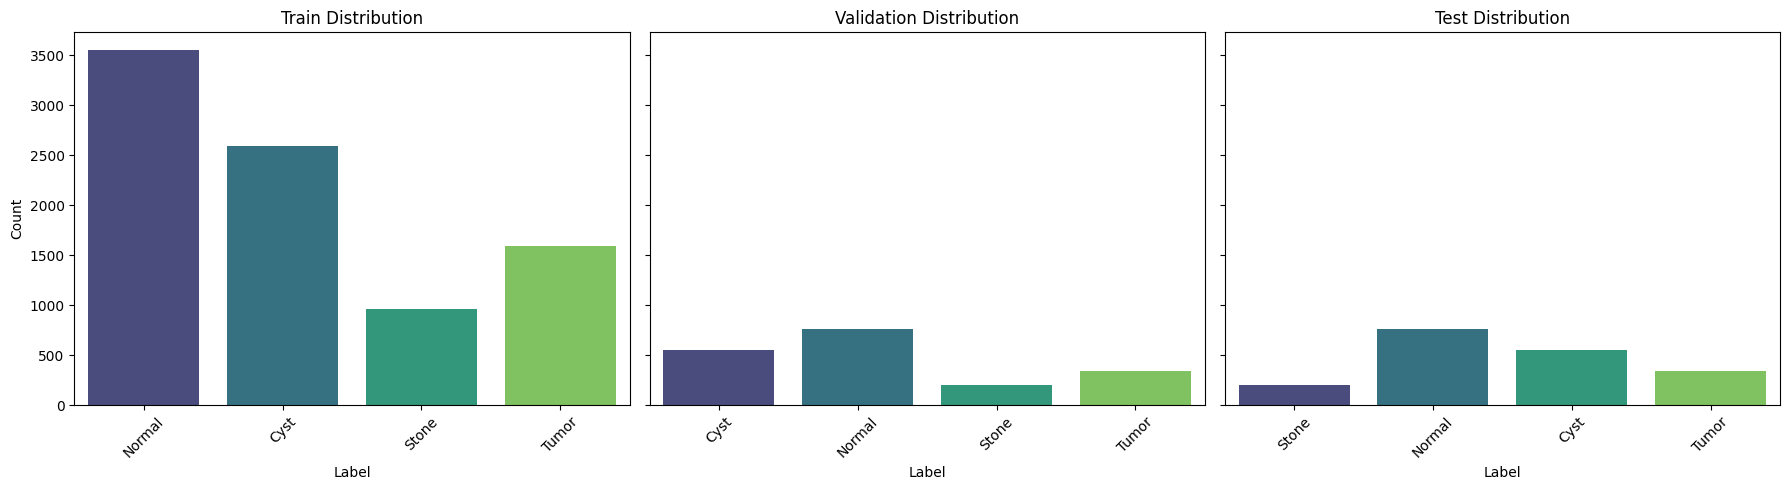

In [ ]:
# ==============================
# 6. Label Distribution Plots
# ==============================

def plot_split_distributions(train, valid, test):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for ax, df_split, name in zip(axes, [train, valid, test], ["Train", "Validation", "Test"]):
        sns.countplot(data=df_split, x='label', ax=ax, palette='viridis')
        ax.set_title(f'{name} Distribution')
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

plot_split_distributions(train_df, valid_df, test_df)


# Image Orientation and Aspect Ratio Analysis

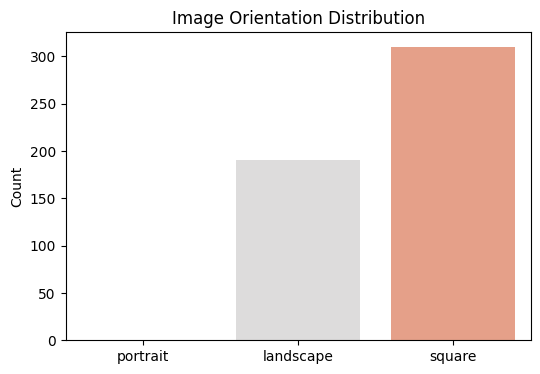

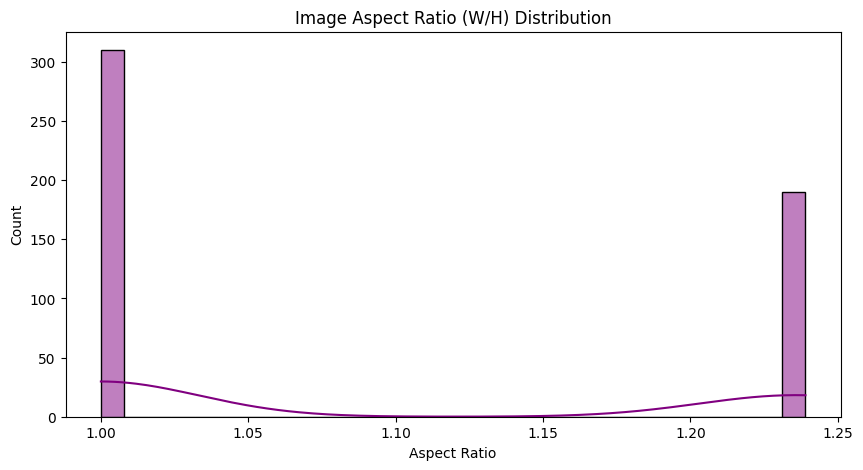

In [ ]:
# ======================================
# 7. Image Aspect Ratio and Orientation
# ======================================

aspect_ratios = []
orientations = {"portrait": 0, "landscape": 0, "square": 0}

for path in df['filepath'].sample(500):
    try:
        img = Image.open(path)
        w, h = img.size
        aspect_ratios.append(w / h)
        if w > h:
            orientations['landscape'] += 1
        elif h > w:
            orientations['portrait'] += 1
        else:
            orientations['square'] += 1
    except:
        continue

# Plot image orientation counts
plt.figure(figsize=(6, 4))
sns.barplot(x=list(orientations.keys()), y=list(orientations.values()), palette='coolwarm')
plt.title("Image Orientation Distribution")
plt.ylabel("Count")
plt.show()

# Plot aspect ratio histogram
plt.figure(figsize=(10, 5))
sns.histplot(aspect_ratios, bins=30, kde=True, color='purple')
plt.title("Image Aspect Ratio (W/H) Distribution")
plt.xlabel("Aspect Ratio")
plt.show()


# File Size Analysis

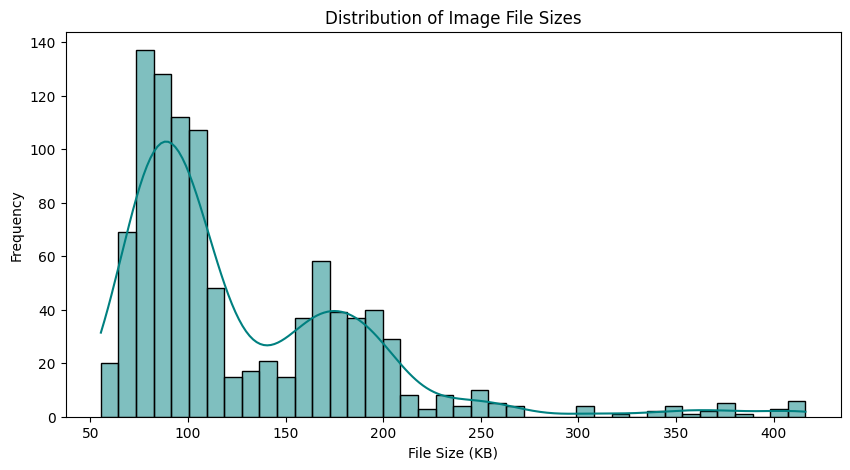

Mean file size: 128.32 KB
Max file size: 416.30 KB
Min file size: 55.36 KB


In [ ]:
# =======================
# 8. Analyzing the File Sizes of Images
# =======================

file_sizes_kb = [os.path.getsize(p) / 1024 for p in df['filepath'].sample(1000)]

plt.figure(figsize=(10, 5))
sns.histplot(file_sizes_kb, bins=40, kde=True, color='teal')
plt.title("Distribution of Image File Sizes")
plt.xlabel("File Size (KB)")
plt.ylabel("Frequency")
plt.show()

print(f"Mean file size: {np.mean(file_sizes_kb):.2f} KB")
print(f"Max file size: {np.max(file_sizes_kb):.2f} KB")
print(f"Min file size: {np.min(file_sizes_kb):.2f} KB")


In [ ]:
# ============================================
# 9. Data Generators For Model Training, Validation and Testing
#    Data Augumentaion for Model Training
# ============================================
img_size = (128, 128)   # Kindly change to (224,224) for better MobileNetV2 accuracy (It works better but slower)
batch_size = 32
class_names = sorted(df['label'].unique())

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
eval_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', classes=class_names
)
val_data = eval_gen.flow_from_dataframe(
    valid_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', classes=class_names, shuffle=False
)
test_data = eval_gen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=img_size, batch_size=batch_size,
    class_mode='categorical', classes=class_names, shuffle=False
)

num_classes = len(class_names)
input_shape = (img_size[0], img_size[1], 3)

Found 8712 validated image filenames belonging to 4 classes.
Found 1867 validated image filenames belonging to 4 classes.
Found 1867 validated image filenames belonging to 4 classes.


In [ ]:
# ============================================
# 10. Define All Required Utility Functions
# ============================================
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names, cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def train_and_evaluate(model, model_name, epochs=12):
    print(f"\n Training {model_name}...\n")
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=3, restore_best_weights=True
            )
        ]
    )

    # -------- Validation --------
    val_preds = model.predict(val_data, verbose=0)
    y_val_pred = np.argmax(val_preds, axis=1)
    y_val_true = val_data.classes
    print(f"\n Validation Report for {model_name}\n")
    print(classification_report(y_val_true, y_val_pred, target_names=class_names))
    plot_confusion_matrix(y_val_true, y_val_pred, class_names,
                          f"{model_name} - Validation Confusion Matrix")

    # -------- Test --------
    test_preds = model.predict(test_data, verbose=0)
    y_test_pred = np.argmax(test_preds, axis=1)
    y_test_true = test_data.classes
    print(f"\n Test Report for {model_name}\n")
    print(classification_report(y_test_true, y_test_pred, target_names=class_names))
    plot_confusion_matrix(y_test_true, y_test_pred, class_names,
                          f"{model_name} - Test Confusion Matrix")

    # -------- Metrics --------
    acc = accuracy_score(y_test_true, y_test_pred)
    prec = precision_score(y_test_true, y_test_pred, average='macro', zero_division=0)
    rec = recall_score(y_test_true, y_test_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_true, y_test_pred, average='macro', zero_division=0)

    model.save(f"{model_name.replace(' ', '_').lower()}.h5")
    print(f" Saved {model_name}")

    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

def plot_metric_bars(metrics_df):
    """Draw: combined chart + one chart per metric."""
    metrics_df = metrics_df.copy()
    metrics_df = metrics_df.set_index("model")[["accuracy", "precision", "recall", "f1_score"]]

    # Combined grouped bar
    plt.figure(figsize=(10,6))
    metrics_df.plot(kind="bar")
    plt.title("Model Performance Comparison (Test Set)")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Individual bars for each metric
    for metric in ["accuracy", "precision", "recall", "f1_score"]:
        plt.figure(figsize=(7,4))
        metrics_df[metric].plot(kind="bar")
        plt.title(f"{metric.capitalize()} by Model (Test Set)")
        plt.ylabel(metric.capitalize())
        plt.ylim(0, 1)
        plt.xticks(rotation=15, ha='right')
        plt.tight_layout()
        plt.show()

In [ ]:
# ============================================
#  11A. Custom CNN (manual hyperparameters)
# ============================================
def cnn_manual():
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape))   # filters1
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(128, (3,3), activation='relu'))                           # filters2
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))                                   # dense_units
    model.add(Dropout(0.3))                                                    # dropout
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),                # lr
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# ============================================
#  11B. LeNet (manual hyperparameters)
# ============================================
def lenet_manual():
    model = Sequential()
    model.add(Conv2D(16, (5,5), activation='tanh',
                     input_shape=input_shape, padding='same'))   # filters1
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (5,5), activation='tanh'))              # filters2
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(120, activation='tanh'))                     # dense1
    model.add(Dense(84, activation='tanh'))                      # dense2
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# ============================================
#  11C. MobileNetV2 (manual hyperparameters)
# ============================================
def mobilenet_manual():
    base = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    base.trainable = False   # freeze base

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)   # FIXED
    x = Dropout(0.3)(x)                    # FIXED
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# ============================================
#  12. Run selected models
# ============================================
results = []

if RUN_CNN:
    cnn_model = cnn_manual()
    results.append(train_and_evaluate(cnn_model, "Custom CNN", epochs=10))

if RUN_LENET:
    lenet_model = lenet_manual()
    results.append(train_and_evaluate(lenet_model, "LeNet", epochs=10))

if RUN_MOBILENET:
    mobilenet_model = mobilenet_manual()
    results.append(train_and_evaluate(mobilenet_model, "MobileNetV2)", epochs=10))

Found 8712 validated image filenames belonging to 4 classes.
Found 1867 validated image filenames belonging to 4 classes.
Found 1867 validated image filenames belonging to 4 classes.

🔧 Training Custom CNN...

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 77s 270ms/step - accuracy: 0.5334 - loss: 1.2360 - val_accuracy: 0.6942 - val_loss: 0.7666
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 262ms/step - accuracy: 0.6681 - loss: 0.8651 - val_accuracy: 0.7225 - val_loss: 0.7487
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 262ms/step - accuracy: 0.6969 - loss: 0.7742 - val_accuracy: 0.6877 - val_loss: 0.8577
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 263ms/step - accuracy: 0.7325 - loss: 0.6861 - val_accuracy: 0.8174 - val_loss: 0.4424
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 264ms/step - accuracy: 0.7501 - loss: 0.6157 - val_accuracy: 0.8190 - val_loss: 0.5046
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 265ms/step - accuracy: 0.7762 - loss: 0.5581 - val_accuracy: 0.8479 - val_loss: 0.3704
Epoc

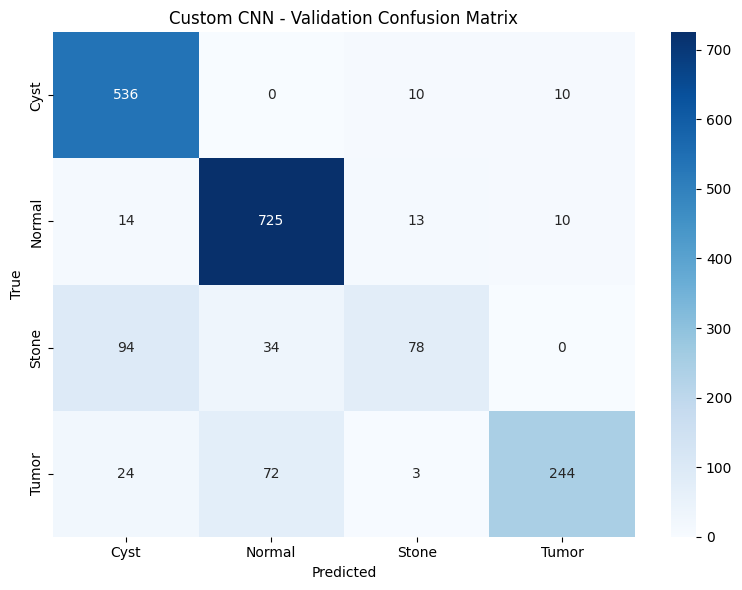


📊 Test Report for Custom CNN

              precision    recall  f1-score   support

        Cyst       0.81      0.96      0.88       557
      Normal       0.85      0.97      0.91       761
       Stone       0.69      0.35      0.46       207
       Tumor       0.93      0.64      0.76       342

    accuracy                           0.84      1867
   macro avg       0.82      0.73      0.75      1867
weighted avg       0.84      0.84      0.82      1867



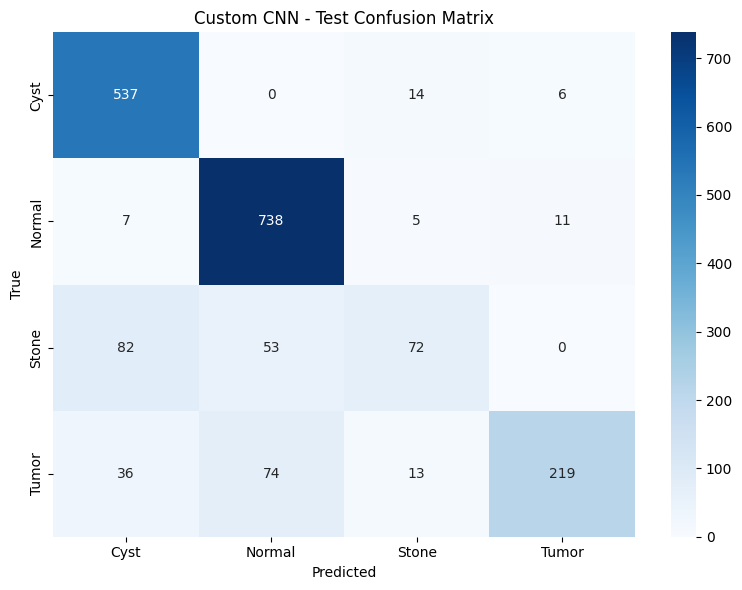

✅ Saved Custom CNN

🔧 Training LeNet...

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 78s 274ms/step - accuracy: 0.5450 - loss: 1.1709 - val_accuracy: 0.6797 - val_loss: 0.7905
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 71s 262ms/step - accuracy: 0.6488 - loss: 0.9073 - val_accuracy: 0.6974 - val_loss: 0.7708
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 264ms/step - accuracy: 0.6583 - loss: 0.8713 - val_accuracy: 0.7354 - val_loss: 0.7262
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 262ms/step - accuracy: 0.6644 - loss: 0.8575 - val_accuracy: 0.6722 - val_loss: 0.7513
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 71s 260ms/step - accuracy: 0.6608 - loss: 0.8552 - val_accuracy: 0.6968 - val_loss: 0.7108
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 263ms/step - accuracy: 0.6645 - loss: 0.8294 - val_accuracy: 0.7204 - val_loss: 0.7221
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 262ms/step - accuracy: 0.6747 - loss: 0.8319 - val_accuracy: 0.6974 - val_loss: 0.7267
Epoch 8/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 71

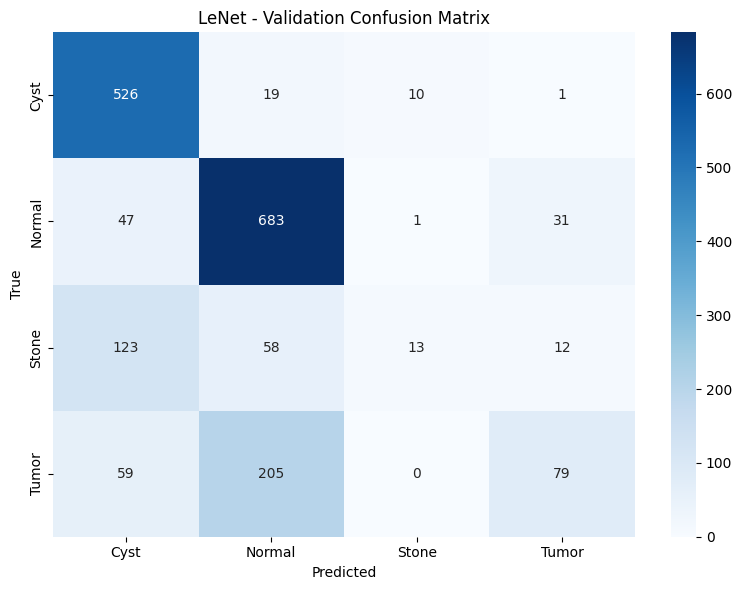


📊 Test Report for LeNet

              precision    recall  f1-score   support

        Cyst       0.73      0.96      0.83       557
      Normal       0.71      0.90      0.79       761
       Stone       0.52      0.06      0.11       207
       Tumor       0.65      0.26      0.37       342

    accuracy                           0.71      1867
   macro avg       0.65      0.55      0.52      1867
weighted avg       0.68      0.71      0.65      1867



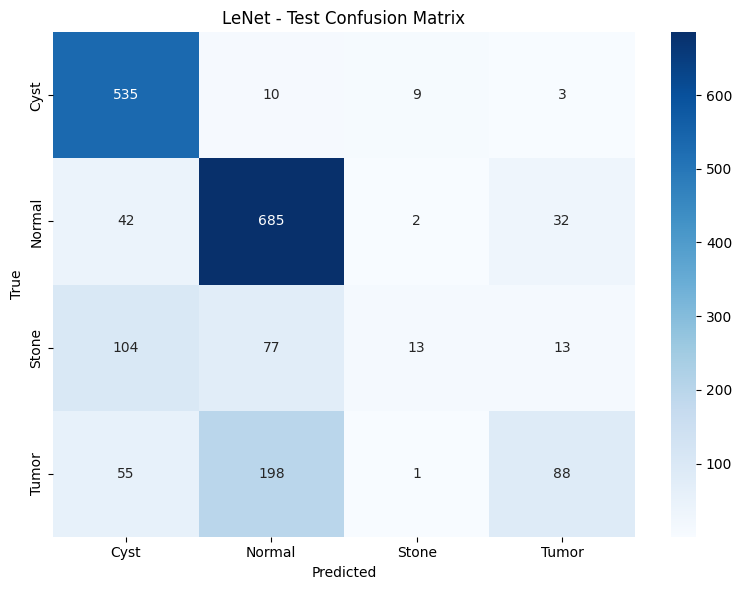

✅ Saved LeNet

🔧 Training MobileNetV2)...

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 127s 390ms/step - accuracy: 0.4559 - loss: 1.3552 - val_accuracy: 0.6797 - val_loss: 0.8338
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 265ms/step - accuracy: 0.6848 - loss: 0.8207 - val_accuracy: 0.7118 - val_loss: 0.7152
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 265ms/step - accuracy: 0.7460 - loss: 0.6709 - val_accuracy: 0.7509 - val_loss: 0.6404
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 73s 266ms/step - accuracy: 0.7780 - loss: 0.5955 - val_accuracy: 0.7574 - val_loss: 0.6188
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 71s 262ms/step - accuracy: 0.8033 - loss: 0.5250 - val_accuracy: 0.8222 - val_loss: 0.5070
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 262ms/step - accuracy: 0.8168 - loss: 0.4853 - val_accuracy: 0.8190 - val_loss: 0.5197
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 72s 265ms/step - accuracy: 0.8376 - loss: 0.4504 - val_accuracy: 0.8270 - val_loss: 0.4591
Epoch 8/10
273/273 ━━━━━━━━━━━━━━━━━━━━

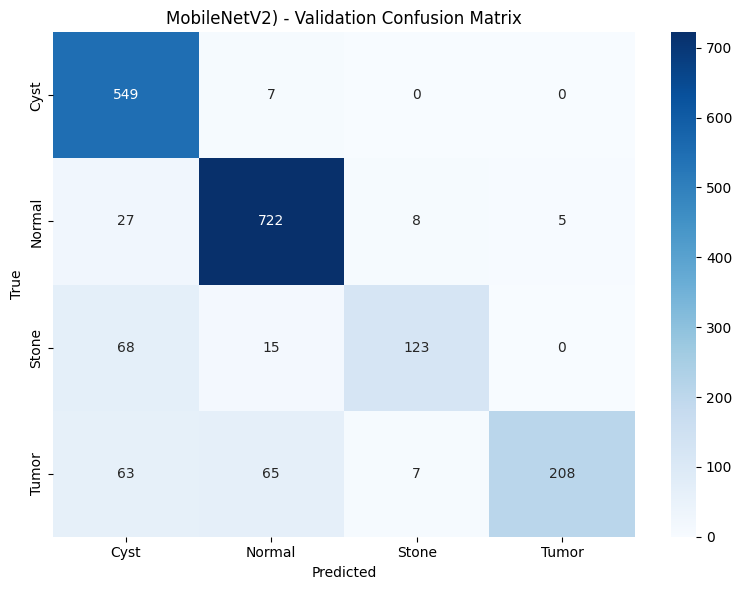


📊 Test Report for MobileNetV2)

              precision    recall  f1-score   support

        Cyst       0.79      0.98      0.88       557
      Normal       0.88      0.93      0.90       761
       Stone       0.84      0.60      0.70       207
       Tumor       0.98      0.63      0.76       342

    accuracy                           0.85      1867
   macro avg       0.87      0.78      0.81      1867
weighted avg       0.87      0.85      0.85      1867



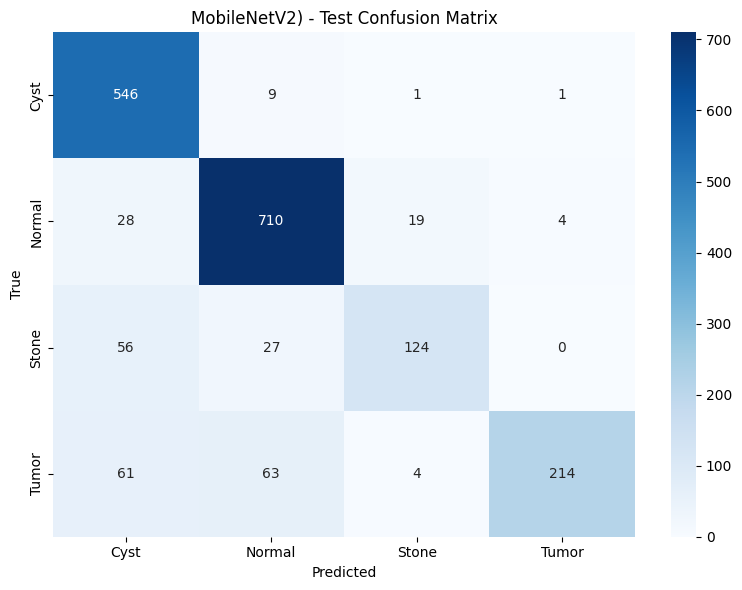

✅ Saved MobileNetV2)


<Figure size 1000x600 with 0 Axes>

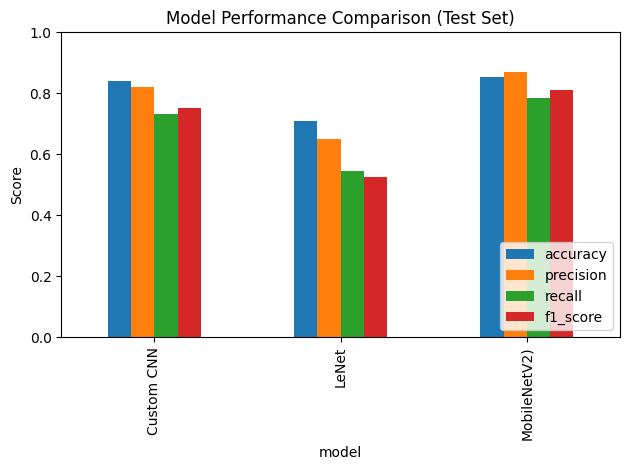

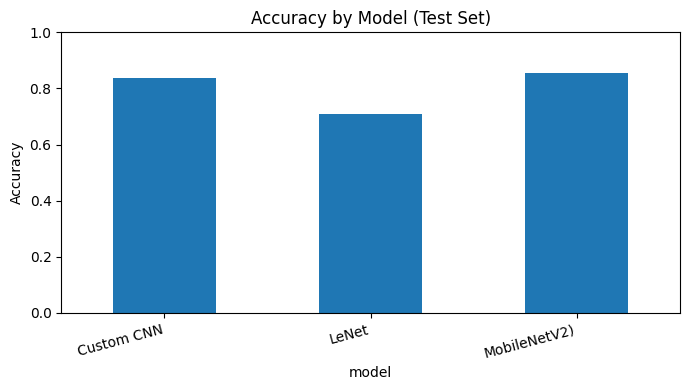

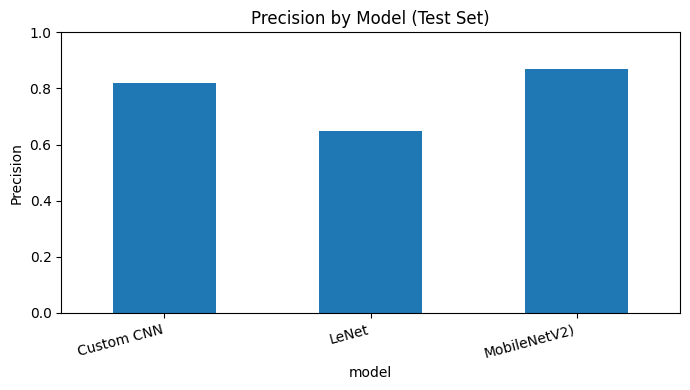

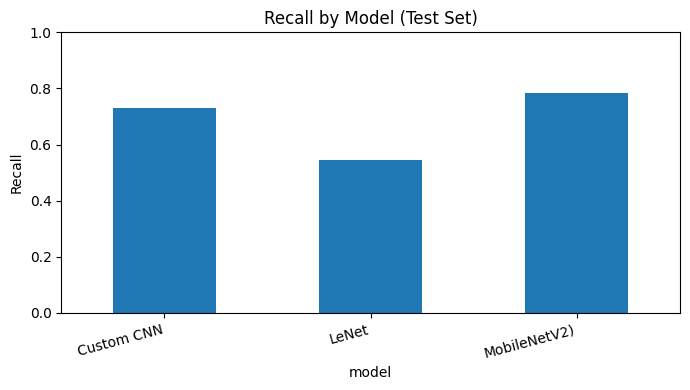

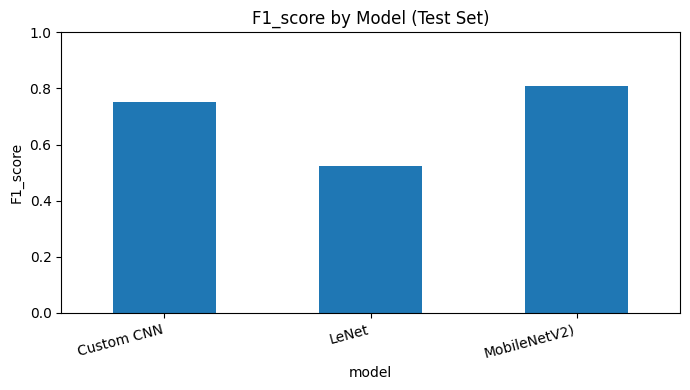

In [ ]:
# ============================================
#  13. Graphs: Accuracy, Precision, Recall, F1 for all models
# ============================================
metrics_df = pd.DataFrame(results)
if not metrics_df.empty:
    plot_metric_bars(metrics_df)
else:
    print("No models were run. Set one of the RUN_* flags to True.")
